In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from joblib import Parallel, delayed

DATA_PATH = '/mnt/cms/version2/merged.pickle'

In [2]:
import cPickle as pickle

with open(DATA_PATH, 'r') as f:
    data = pickle.load(f)

labels = np.load('/mnt/cms/version2/labels.npy')

In [3]:
non_zero_lumi_index = np.where(
    (data['_instantLumi_minibias'] != 0.0) | \
    (data['_instantLumi_muons'] != 0.0) | \
    (data['_instantLumi_photons'] != 0.0)
)[0]

In [4]:
not_features = [
    '_luminosityBlock',
    '_run',
    '_instantLumi_minibias',
    '_instantLumi_muons',
    '_instantLumi_photons'
]

features = sorted(set(data.columns) - set(not_features))

X = data[features].values
y = labels
weights = data['_instantLumi_minibias'].values

In [5]:
print 'Non-zero luminosity:', non_zero_lumi_index.shape[0], 'lumisections'

Non-zero luminosity: 26046 lumisections


In [6]:
def build_predictions(clf, X, y, thr_q = 0.97,
                      n_folds = 10, max_loss_rate = 0.0, max_pollution_rate = 0.0,
                      title = ''):
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc
    from sklearn.cross_validation import StratifiedKFold
    
    cv = StratifiedKFold(y, n_folds=n_folds, shuffle=True, random_state=7777)
    proba = np.zeros(X.shape[0])
    
    train_indx, test_indx = iter(cv).next()
    clf.fit(X[train_indx, :], y[train_indx])
    proba[test_indx] = clf.predict_proba(X[test_indx, :])[:, 1]

    
    fpr, tpr, thr_roc = roc_curve(y[test_indx], proba[test_indx])
    auc_score = auc(fpr, tpr)
    
    precision, recall, thr = precision_recall_curve(y[test_indx], proba[test_indx])
    pr_auc = auc(precision, recall, reorder = True)
    
    plt.figure(figsize=(8, 8))
    plt.hist([
            proba[y_test == 0, 1],
        ])
    
    thr = np.hstack([thr, [1.0]])
    
    pollution = 1.0 - precision
    loss = 1.0 - recall
    
    fs, axs = plt.subplots(1, 3, figsize=(14, 4))
    plt.suptitle(title)
    
    axs[0].set_title('ROC curve')
    axs[0].plot([0, 1], [0, 1], '--')
    axs[0].plot(fpr, tpr, label = "AUC = %.2f" % auc_score)
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend(loc='lower right')
    
    axs[1].set_title('Pollution-Loss curve')
    axs[1].plot([1, 1], [0, 0], '--')
    axs[1].plot(pollution, loss, label = "AUC = %.2f" % pr_auc)
    axs[1].set_xlabel('Pollution Rate')
    axs[1].set_ylabel('Loss Rate')
    axs[1].legend(loc='lower right')
    
    axs[2].set_title('Pollution/Loss rates')
    axs[2].plot(thr, pollution, label='pollution rate')
    axs[2].plot(thr, loss, label='loss rate')
    axs[2].set_xlabel('threshold')
    axs[2].set_ylabel('rate')
    axs[2].legend(loc = 'upper left')

    plt.show()
    
#     thr_high = np.min(thr[pollution <= max_pollution_rate])
#     thr_low = np.max(thr[loss <= max_loss_rate])
    
    thr_high = np.percentile(thr[pollution <= max_pollution_rate], q=(1.0 - thr_q) * 100.0)
    thr_low = np.percentile(thr[loss <= max_loss_rate], q=thr_q * 100.0)
    
    return clf, thr_low, thr_high

In [12]:
def offline_learning(clf, X, y):
    from sklearn.cross_validation import train_test_split
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import roc_auc_score

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    clf.fit(X_train, y_train)
    proba = clf.predict_proba(X_test)[:, 1]
    
    precision, recall, thr = precision_recall_curve(y_test, proba)
    thr = np.hstack([thr, 1.0])
    
    
    print roc_auc_score(y_test, proba)
    print thr.shape
    
    pollution = 1.0 - precision
    loss = 1.0 - recall
    
    n = thr[::10].shape[0]
    
    rrs = np.ones(shape=(n, n))
    lrs = np.ones(shape=(n, n))
    prs = np.ones(shape=(n, n))
    
    TP = np.zeros(shape=n)
    TN = np.zeros(shape=n)

    FP = np.zeros(shape=n)
    FN = np.zeros(shape=n)
    
    FPR = np.zeros(shape=n)
    TPR = np.zeros(shape=n)
    
    for i, cut_low in enumerate(thr[::10]):
        TN[i] = np.sum((proba <= cut_low) & (y_test == 0))
        FN[i] = np.sum((proba <= cut_low) & (y_test == 1))
    
    for i, cut_high in enumerate(thr[::10]):
        TP[i] = np.sum((proba >= cut_high) & (y_test == 1))
        FP[i] = np.sum((proba >= cut_high) & (y_test == 0))
    
    for i, cut_low in enumerate(thr[::10]):
        for j, cut_high in enumerate(thr[::10]):
            rrs[i, j] = np.mean((proba > cut_low) & (proba < cut_high))
            
            lrs[i, j] = float(FN[i]) / (TP[j] + FN[i])
            prs[i, j] = float(FP[j]) / (TP[j] + FP[i])

    return rrs, lrs, prs, thr

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=128, min_samples_leaf=10, n_jobs=-1, random_state=7777)
rrs, lrs, prs, thr = offline_learning(clf, X, y)

0.997594826713
(5895,)


In [15]:
font = {
    'family' : 'normal',
    'weight' : 'normal',
    'size'   : 16
}

import matplotlib
matplotlib.rc('font', **font)

In [16]:
lrs

array([[  2.23513634e-04,   2.23563604e-04,   2.23563604e-04, ...,
          6.17283951e-03,   7.46268657e-03,   1.01010101e-02],
       [  2.23513634e-04,   2.23563604e-04,   2.23563604e-04, ...,
          6.17283951e-03,   7.46268657e-03,   1.01010101e-02],
       [  2.23513634e-04,   2.23563604e-04,   2.23563604e-04, ...,
          6.17283951e-03,   7.46268657e-03,   1.01010101e-02],
       ..., 
       [  4.90894605e-01,   4.90950484e-01,   4.90950484e-01, ...,
          9.64014305e-01,   9.70085470e-01,   9.77782816e-01],
       [  4.93259318e-01,   4.93315205e-01,   4.93315205e-01, ...,
          9.64341085e-01,   9.70358814e-01,   9.77987421e-01],
       [  4.94519155e-01,   4.94575045e-01,   4.94575045e-01, ...,
          9.64513996e-01,   9.70503438e-01,   9.78095664e-01]])

In [17]:
prs

array([[ 0.27480545,  0.27322847,  0.27128263, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.27525171,  0.27367224,  0.27172324, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.27578913,  0.27420667,  0.27225386, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.37894031,  0.37678891,  0.37410555, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37894031,  0.37678891,  0.37410555, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37894031,  0.37678891,  0.37410555, ...,  0.        ,
         0.        ,  0.        ]])

In [18]:
rrs

array([[ 0.        ,  0.00122549,  0.00269608, ...,  0.73602941,
         0.73946078,  0.74375   ],
       [ 0.        ,  0.        ,  0.00134804, ...,  0.73468137,
         0.73811275,  0.74240196],
       [ 0.        ,  0.        ,  0.        , ...,  0.73321078,
         0.73664216,  0.74093137],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00330882,  0.00759804],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.00257353],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

/opt/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


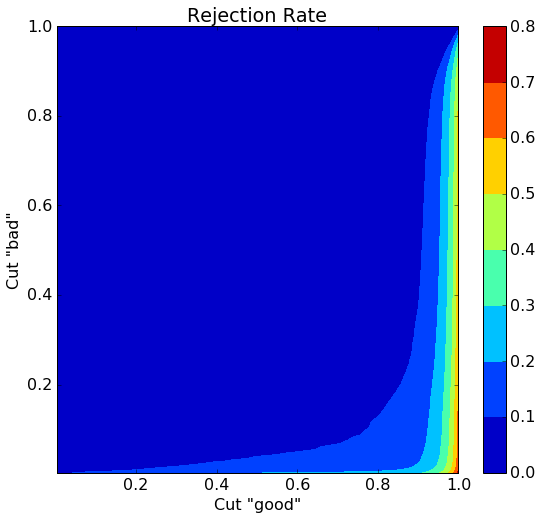

In [19]:
cuts_low = thr[::10]
cuts_high = thr[::10]

plt.figure(figsize=(9, 8))
plt.contourf(
    cuts_high, cuts_low, rrs,
#     levels = np.linspace(0., 1., num=21)
)
plt.title('Rejection Rate')
plt.ylabel('Cut "bad"')
plt.xlabel('Cut "good"')
plt.colorbar()

In [ ]:
plt.scatter(prs.ravel(), lrs.ravel())

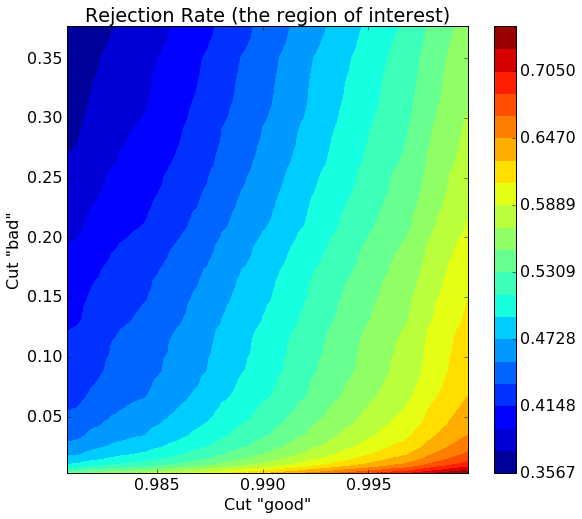

In [52]:
n = 150

plt.figure(figsize=(9, 8))
plt.contourf(
    cuts_high[-n:], cuts_low[:n], rrs[:n, -n:],
    levels = np.linspace(np.min(rrs[:n, -n:]), np.max(rrs[:n, -n:]), num=21)
)
plt.title('Rejection Rate (the region of interest)')
plt.ylabel('Cut "bad"')
plt.xlabel('Cut "good"')
plt.colorbar()

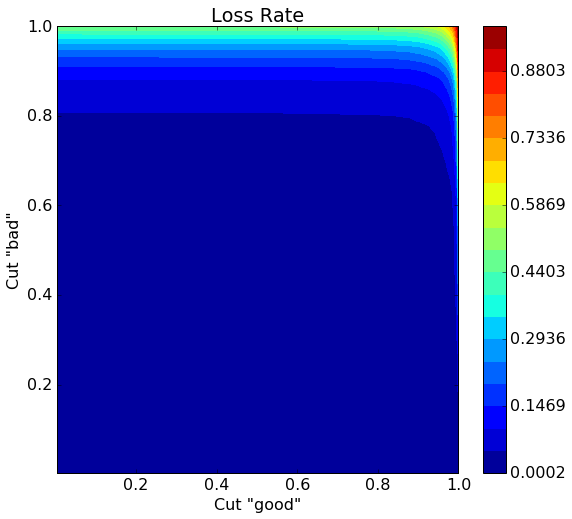

In [53]:
plt.figure(figsize=(9, 8))
plt.contourf(
    cuts_high, cuts_low, lrs,
    levels = np.linspace(np.min(lrs), np.max(lrs), num=21)
)
plt.title('Loss Rate')
plt.ylabel('Cut "bad"')
plt.xlabel('Cut "good"')
plt.colorbar()

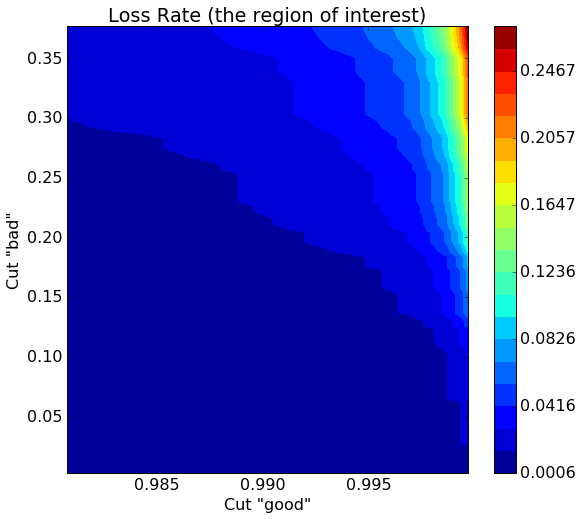

In [57]:
plt.figure(figsize=(9, 8))
plt.contourf(
    cuts_high[-n:], cuts_low[:n], lrs[:n, -n:],
    levels = np.linspace(np.min(lrs[:n, -n:]), np.max(lrs[:n, -n:]), num=21)
)
plt.title('Loss Rate (the region of interest)')
plt.ylabel('Cut "bad"')
plt.xlabel('Cut "good"')
plt.colorbar()

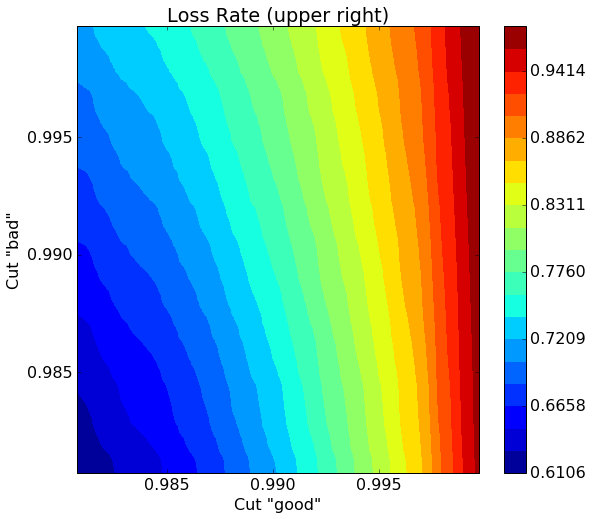

In [58]:
plt.figure(figsize=(9, 8))
plt.contourf(
    cuts_high[-n:], cuts_low[-n:], lrs[-n:, -n:],
    levels = np.linspace(np.min(lrs[-n:, -n:]), np.max(lrs[-n:, -n:]), num=21)
)
plt.title('Loss Rate (upper right)')
plt.ylabel('Cut "bad"')
plt.xlabel('Cut "good"')
plt.colorbar()

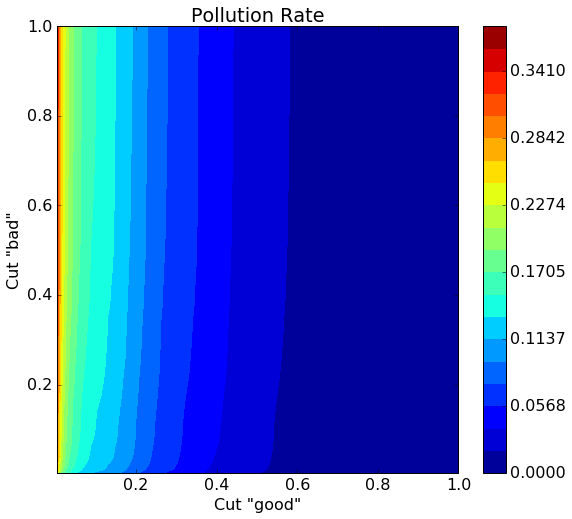

In [59]:
plt.figure(figsize=(9, 8))
plt.contourf(
    cuts_high, cuts_low, prs,
    levels = np.linspace(np.min(prs), np.max(prs), num=21)
)
plt.title('Pollution Rate')
plt.ylabel('Cut "bad"')
plt.xlabel('Cut "good"')
plt.colorbar()

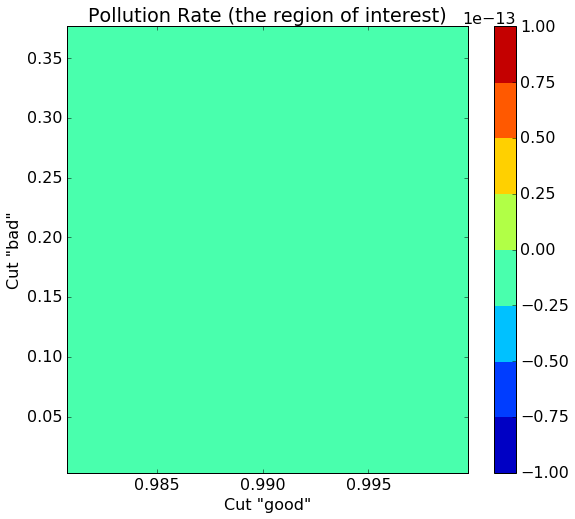

In [62]:
plt.figure(figsize=(9, 8))
plt.contourf(
    cuts_high[-n:], cuts_low[:n], prs[:n, -n:],
#     levels = np.linspace(np.min(prs[:n, -n:]), np.max(prs[:n, -n:]), num=21)
)
plt.title('Pollution Rate (the region of interest)')
plt.ylabel('Cut "bad"')
plt.xlabel('Cut "good"')
plt.colorbar()

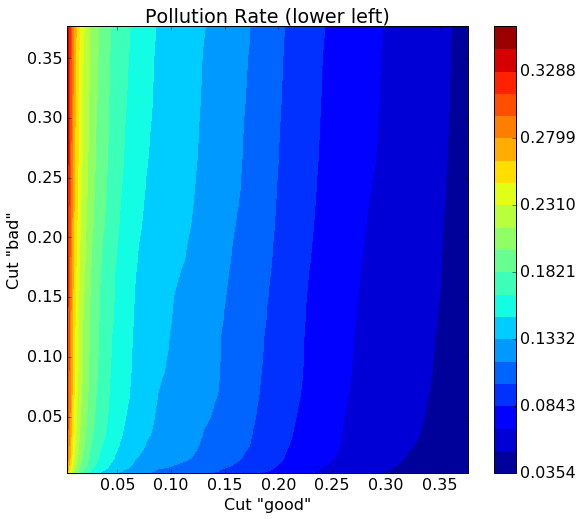

In [63]:
plt.figure(figsize=(9, 8))
plt.contourf(
    cuts_high[:n], cuts_low[:n], prs[:n, :n],
    levels = np.linspace(np.min(prs[:n, :n]), np.max(prs[:n, :n],), num=21)
)
plt.title('Pollution Rate (lower left)')
plt.ylabel('Cut "bad"')
plt.xlabel('Cut "good"')
plt.colorbar()

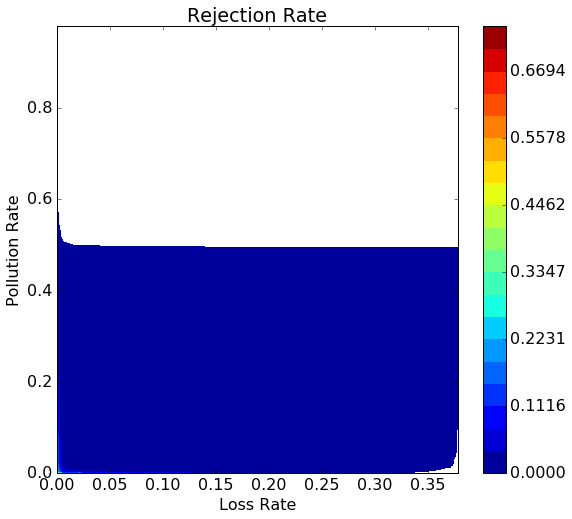

In [67]:
plt.figure(figsize=(9, 8))
plt.contourf(
    prs, lrs, rrs,
    levels = np.linspace(np.min(rrs), np.max(rrs,), num=21)
)
plt.title('Rejection Rate')
plt.ylabel('Pollution Rate')
plt.xlabel('Loss Rate')
plt.colorbar()

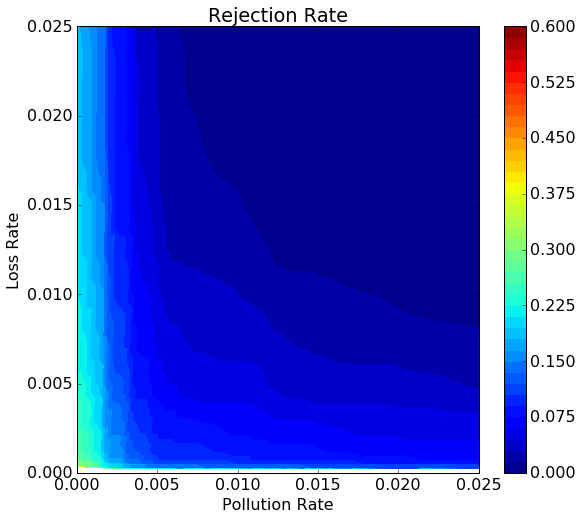

In [100]:
plt.figure(figsize=(9, 8))

plt.contourf(
    prs, lrs, rrs,
    levels = np.linspace(np.min(rrs), 0.6, num=41)
)
plt.xlim([0.0, 0.025])
plt.ylim([0.0, 0.025])
plt.title('Rejection Rate')
plt.ylabel('Loss Rate')
plt.xlabel('Pollution Rate')
plt.colorbar()

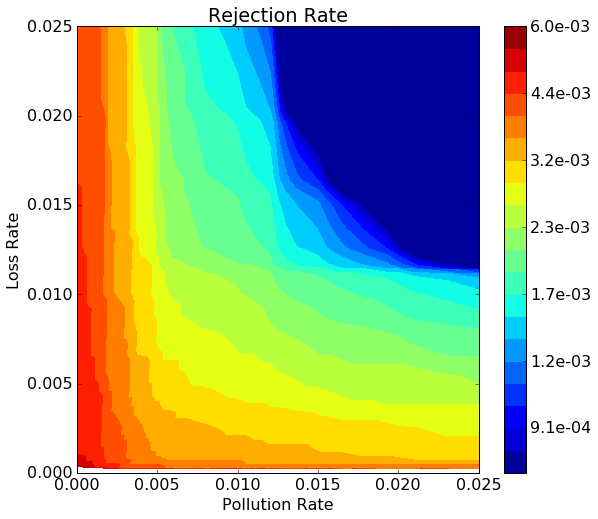

In [101]:
plt.figure(figsize=(9, 8))

x = rrs.copy()

x[x <= np.exp(-7)] = np.exp(-7)
x = np.log(x)

plt.contourf(
    prs, lrs, x,
    levels = np.linspace(np.min(x), np.log(0.5), num=21)
)

plt.xlim([0.0, 0.025])
plt.ylim([0.0, 0.025])
plt.title('Rejection Rate')
plt.ylabel('Loss Rate')
plt.xlabel('Pollution Rate')
cb = plt.colorbar()
cb.set_ticklabels( ['%.1e' % t for t in np.exp(np.linspace(np.min(x), np.log(0.5), num=21))])

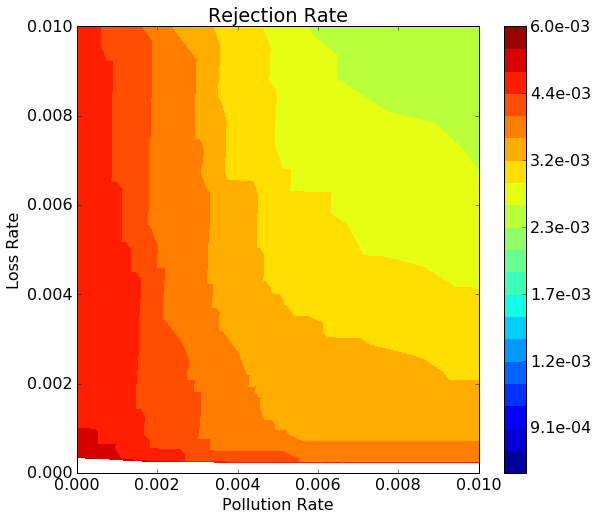

In [102]:
plt.figure(figsize=(9, 8))

x = rrs.copy()

x[x <= np.exp(-7)] = np.exp(-7)
x = np.log(x)

plt.contourf(
    prs, lrs, x,
    levels = np.linspace(np.min(x), np.log(0.5), num=21)
)

plt.xlim([0.0, 0.01])
plt.ylim([0.0, 0.01])
plt.title('Rejection Rate')
plt.ylabel('Loss Rate')
plt.xlabel('Pollution Rate')
cb = plt.colorbar()
cb.set_ticklabels( ['%.1e' % t for t in np.exp(np.linspace(np.min(x), np.log(0.5), num=21))])

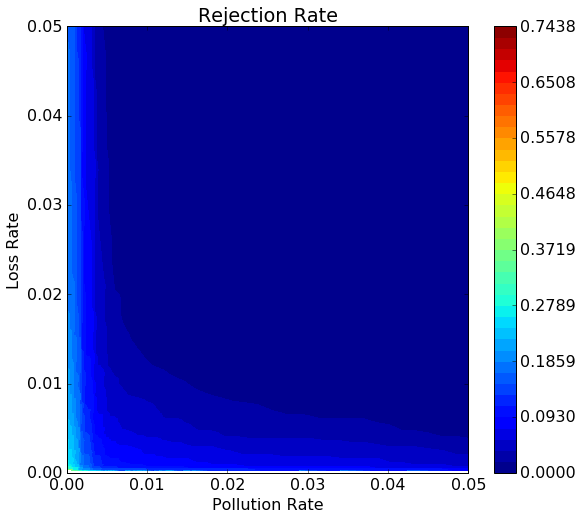

In [83]:
plt.figure(figsize=(9, 8))

plt.contourf(
    prs, lrs, rrs,
    levels = np.linspace(np.min(rrs), np.max(rrs), num=41)
)
plt.xlim([0.0, 0.05])
plt.ylim([0.0, 0.05])
plt.title('Rejection Rate')
plt.ylabel('Loss Rate')
plt.xlabel('Pollution Rate')
plt.colorbar()

NameError: name 'alrs' is not defined

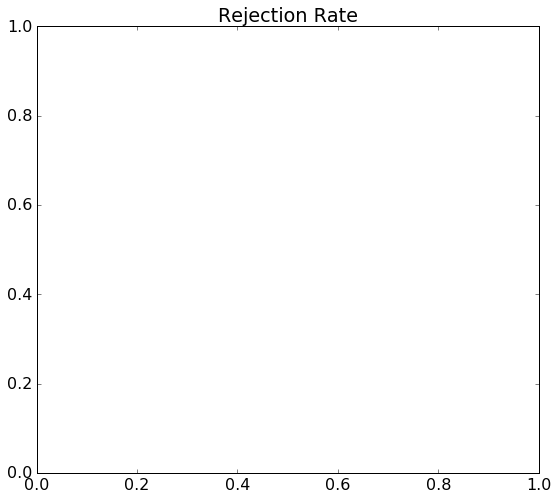

In [64]:
plt.figure(figsize=(9, 8))
plt.title('Rejection Rate')
plt.contourf(alrs, aprs, np.mean(rrs[:, :, -4:], axis=2), cmap=plt.cm.Reds)
plt.xlabel('Average Loss Rate')
plt.ylabel('Averange Pollution Rate')
plt.colorbar()

In [ ]:
plt.figure(figsize=(9, 8))
plt.title('Average Loss Rate')
plt.contourf(lrs, prs, alrs.T, cmap=plt.cm.Reds)
plt.xlabel('Loss Rate constraint')
plt.ylabel('Pollution Rate constraint')
plt.colorbar()

In [ ]:
plt.figure(figsize=(9, 8))
plt.title('Average Pollution Rate')
plt.contourf(prs, lrs, aprs.T, cmap=plt.cm.Reds)
plt.xlabel('Loss Rate constraint')
plt.ylabel('Pollution Rate constraint')
plt.colorbar()

In [ ]:
plt.matshow(arrs, cmap=plt.cm.Reds)
plt.xlabel('Pollution rate')
plt.ylabel('Loss rate')
plt.colorbar()